## Simulation test case - optimize mesh to make triangles equilateral

Let's start with a simple test case to see `triangulax` in action. The goal is to move the vertices $\mathbf{v}_i$ of a triangulation so that all triangle edge lengths are as close to some $\ell_0$ as possible. 
We specify a pseudo-energy $E=\sum_{ij} (|\mathbf{v}_i-\mathbf{v}_j| - \ell_0)^2$, and then minimize it using the JAX-provided gradients w.r.t the vertex positions. 

This defines the "forward pass" of our "dynamical" model. In a second step, we can meta-optimize over the model parameters (here $\ell_0$), to make the dynamics return some desired shape.

### JAX-compatible scientific computing libraries - useful in future steps
```
import diffrax # ODE solvers
import lineax # linear solvers
import optimistix # optimisation (scientific-computing style, e.g. conjugate gradient)
import optax # optimisation (ML-style, e.g. ADAM)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy

from tqdm.notebook import tqdm

In [2]:
import jax
import jax.numpy as jnp

In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
jax.config.update('jax_log_compiles', False)

In [4]:
import diffrax
import equinox as eqx

# equinox has automated "filtering" of JAX-transforms. So we can work with objects which are not just pytrees of arrays
# (like neural networks) and appy jit, vmap etc

In [5]:
from jaxtyping import Float

from typing import Tuple
import dataclasses
import functools

In [11]:
# import previously defined modules

from triangulax import trigonometry as trg
from triangulax import mesh as msh
from triangulax.triangular import TriMesh
from triangulax.mesh import HeMesh, GeomMesh
from triangulax import geometry as geom
from triangulax import linops as lin



### Load example mesh


In [12]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)

hemesh

  o flat_tri_ecmc


HeMesh(N_V=131, N_HE=708, N_F=224)

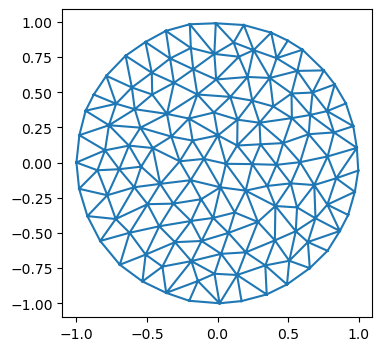

In [13]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, mesh.faces)
plt.axis("equal");

### Forward pass - minimize energy

We write the energy_function using a geommesh as an argument. This is overkill for present purposes ince only the vertex positions matter, but is useful to test the machinery. For more complicated simulations, we will want to use GeomMesh as a wrapper for the various arrays.

In [26]:
@jax.jit
def energy_function(geommesh: GeomMesh, hemesh: HeMesh, ell_0: float=1):
    edge_lengths = geom.get_he_length(geommesh.vertices, hemesh)
    edge_energy = jnp.mean((edge_lengths/ell_0-1)**2) # this way, term is "auto-normalized"
    # let's add a term for the triangle areas. Use the oriented area to penalize invalid mesh configurations
    a_0 = (np.sqrt(3)/4) * ell_0**2 # area of equilateral triangle
    tri_area = geom.get_oriented_triangle_areas(geommesh.vertices, hemesh)
    area_energy = jnp.mean((tri_area/a_0-1)**2)
    #jax.debug.print("E_l: {E_l}, E_a: {E_a}",  E_l=edge_energy, E_a=area_energy)
    # this is how you can print inside a JITed-function
    return edge_energy + area_energy

In [27]:
val, grad = jax.value_and_grad(energy_function)(geommesh, hemesh) # computing value and gradient of the energy
val, grad, grad.vertices.shape # the gradient is another GeomMesh. 1.60519339

(Array(1.60519339, dtype=float64),
 GeomMesh(D=2,N_V=131, N_HE=708, N_F=224),
 (131, 2))

In [28]:
connectivity_grad = jax.grad(energy_function, argnums=1, allow_int=True)(geommesh, hemesh)
# we can even compute the gradient w.r.t to the connectivity matrix. It is also a HeMesh
connectivity_grad, connectivity_grad.dest[0] # whatever that means

(HeMesh(N_V=131, N_HE=708, N_F=224), np.void((b'',), dtype=[('float0', 'V')]))

#### Energy optimization

Let's follow the patterns for writing a simulation time-stepping loop described in notebook 02. 


In [29]:
# time-stepping function
@jax.jit
def make_step(geommesh: GeomMesh, hemesh: HeMesh,
              current_time: Float[jax.Array, ""], next_time: Float[jax.Array, ""], ell_0: float = 1):
    loss, grad = jax.value_and_grad(energy_function)(geommesh, hemesh, ell_0=ell_0)
    updated_vertices = geommesh.vertices - (next_time-current_time)*grad.vertices
    geommesh = dataclasses.replace(geommesh, vertices=updated_vertices)
    return (geommesh, hemesh), loss # explicitly return the hemesh - may need to be updated by flips!

In [30]:
# simulation timesteps
step_size = 0.02
N_steps = 20000
timepoints = step_size * jnp.arange(N_steps) 

# parameters of the energy
ell_0 = 0.5

# inital condition
init = ((geommesh, hemesh), timepoints[0])

# scanning function - applied at each time-step
def scan_function(carry, next_time: jax.Array):
    (geommesh, hemesh), current_time = carry 
    (geommesh, hemesh), loss = make_step(geommesh, hemesh, current_time, next_time, ell_0=ell_0)
    return ((geommesh, hemesh), next_time), loss # log the loss/energy

In [31]:
# run the simulation
((geommesh_optimized, hemesh_optimized), _), loss = jax.lax.scan(scan_function, init, timepoints) 

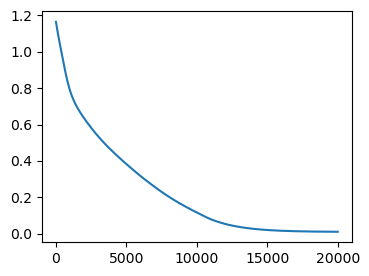

In [32]:
fig = plt.figure(figsize=(4, 3))
plt.plot(loss)

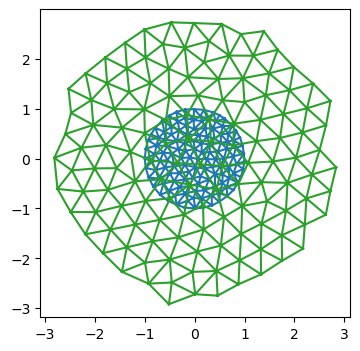

In [92]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_optimized.vertices.T, hemesh_optimized.faces)
plt.axis("equal");

#### Using an ODE solver - `diffrax`

Above, we implemented "gradient descent" for the pseudo-energy, or, equivalently, a basic forward-Euler scheme for the ODE $\partial_t \mathbf{v}_i = - \nabla_{\mathbf{v}_i} E$. For more complicated models, and to minimize coding effort, it makes sense to use a pre-made ODE solver instead. The `diffrax` library implements ODE and SDE solvers in JAX and is compatible with autodiff (you can differentiate through the solver), since it was designed for neural differential equations.

For "adiabatic" dynamics, which involve mimizing an energy at every timestep, we can use the "optimistix" library.

The below is based on the [Stepping through a solver](https://docs.kidger.site/diffrax/usage/manual-stepping/) tutorial in `diffrax`. The reason we want to step through the solver one-by-one is to carry out T1s (in future simulations).

In [33]:
# define the RHS for the ODE solver
@jax.jit
def vector_field(t, y, args):
    return jax.tree_util.tree_map(lambda x: -1*x, jax.grad(energy_function)(y, *args))
term = diffrax.ODETerm(vector_field)

# define time parameters and initial condition
dt = 0.05
t0 = 0.0
t1 = 1000.0
step_times = jnp.arange(t0, t1, dt)

y0 = geommesh
args = (hemesh, ell_0)

# initialize the solver
solver = diffrax.Tsit5()
y = y0
state = solver.init(term, t0, t0+dt, y0, args)

In [34]:
# scan through the solve

def scan_fun(carry, t):
    state, y, tprev = carry 
    y, _, _, state, _ = solver.step(term, tprev, t, y, args, state, made_jump=False)
    return (state, y, t), None

init = (state, y0, t0)
(state, y, t), _ = jax.lax.scan(scan_fun, init, step_times[1:])

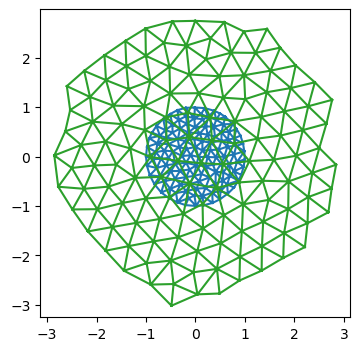

In [35]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*y0.vertices.T, hemesh.faces)
plt.triplot(*y.vertices.T, hemesh.faces)
plt.axis("equal");

### Meta-training

One use case for JAX is to _differentiate through_ a scientific simulation, allowing one to optimize the simulation parameters towards some some desired behavior. For example, we may wish to find a triangulation dynamics that creates some target shape.

As a toy example, let's take the above "dynamics" which minimizes the pseudo-energy to make all triangles equilateral. It depends on the parameter $\ell_0$. Relaxation of the pseudo-energy for some number of steps defines our "forward pass". Let's try to optimize $\ell_0$ so that the tissue, at the end of the energy relaxation, has some target size (of course, a contrived problem, since we know the solution from the start).

First, we wrap our dynamical model as an `eqx.Module`, so we can optimize it just like a neural net.

In [36]:
class RelaxationDynamics(eqx.Module):
    ell_0: jax.Array
    step_size : float = eqx.field(static=True)
    N_steps : int = eqx.field(static=True)

    def __call__(self, initial_geommesh: GeomMesh, initial_hemesh: HeMesh) -> Tuple[GeomMesh, HeMesh]:
        init = ((initial_geommesh, initial_hemesh), 0)
        def scan_fun(i, carry):
            (geommesh, hemesh), _ = carry
            return make_step(geommesh, hemesh, ell_0=self.ell_0,
                             current_time=i*self.step_size, next_time=(i+1)*self.step_size)
        (geommesh_optimized, hemesh_optimized), _ = jax.lax.fori_loop(0, N_steps, scan_fun, init, unroll=None)
        return geommesh_optimized, hemesh_optimized

#### Define Meta-training loss

Now we need to define our meta-training loss. In this case, it's just the deviation of the average edge length from the total.
Note how the meta-loss is _distinct_ from the pseudo-energy we minimize during the forward pass.

Let's use the `equinox` library to handle our problem, in anticipation of more complex ones down the line.

In [39]:
# define the meta-loss

def meta_loss(model: RelaxationDynamics, initial_geommesh: GeomMesh, initial_hemesh: HeMesh,  meta_ell0: float) -> float:
    geommesh_optimized, hemesh_optimized = model(initial_geommesh, initial_hemesh)
    lengths = geom.get_he_length(geommesh_optimized.vertices,  hemesh_optimized)
    return jnp.mean((lengths/meta_ell0-1)**2)

In [40]:
# initialize the model, and test the meta loss

initial_ell0 = 0.4
meta_ell0 = 0.3

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)
model_initial(geommesh, hemesh), meta_loss(model_initial, geommesh, hemesh, meta_ell0=meta_ell0)

((GeomMesh(D=2,N_V=131, N_HE=708, N_F=224),
  HeMesh(N_V=131, N_HE=708, N_F=224)),
 Array(0.13074658, dtype=float64))

#### Batching

To evaluate the loss, we want to average over a bunch of initial conditions. These are analogous to _batches_ in a normal ML problem.

In [41]:
## Let's create a bunch of meshes with different initial positions and see if we can batch over them using vmap

key = jax.random.key(0)
sigma = 0.02
N_batch = 3

batch_geom = []
batch_he = []
for i in range(N_batch):
    key, subkey = jax.random.split(key)
    random_noise = jax.random.normal(subkey, shape=geommesh.vertices.shape)
    batch_geom.append(dataclasses.replace(geommesh, vertices=geommesh.vertices+sigma*random_noise))
    batch_he.append(copy.copy(hemesh))

# we use a jax.tree.map to "push" the list axis into the underlying arrays.
# the result is a single mesh object with batch axes

batch_he_array = msh.tree_stack(batch_he)
batch_geom_array = msh.tree_stack(batch_geom)

batch_geom_array, batch_geom_array.vertices.shape

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), (3, 131, 2))

In [42]:
# We can apply the simulation and upack the results into a list

batch_geom_array_out, batch_he_array_out = jax.vmap(model_initial)(batch_geom_array, batch_he_array) 
batch_geom_out = msh.tree_unstack(batch_geom_array_out)
batch_he_out = msh.tree_unstack(batch_he_array_out)

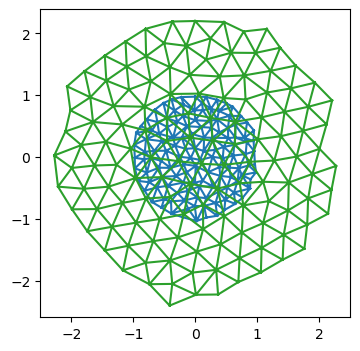

In [43]:
# still works

i = 2
fig = plt.figure(figsize=(4, 4))
plt.triplot(*batch_geom[i].vertices.T, batch_he[i].faces)
plt.triplot(*batch_geom_out[i].vertices.T, batch_he_out[i].faces)
plt.axis("equal");

##### Compute the batched loss

In [44]:
# This is the right way to vmap the loss
jax.vmap(meta_loss, in_axes=(None, 0, 0, None))(model_initial, batch_geom_array, batch_he_array, 0.8) 

Array([0.24862355, 0.24863542, 0.24863226], dtype=float64)

In [45]:
# check against non-vmapped version. pretty similar, floating point errors likely at origin of differences
[meta_loss(model_initial, batch_geom_out[i], batch_he_out[i], 0.8) for i in range(3)] 

[Array(0.24848931, dtype=float64),
 Array(0.24848805, dtype=float64),
 Array(0.2484898, dtype=float64)]

### Meta-optimization

Now we are in a position to "optiomize" our model parameter `ell_0`. Based on [equinox CNN tutorial](https://docs.kidger.site/equinox/examples/mnist/#training).

In [46]:
def batched_meta_loss(model, batch_geom_array, batch_he_array, meta_ell0):
    return jnp.mean(jax.vmap(meta_loss, in_axes=(None, 0,0, None))(model, batch_geom_array, batch_he_array, meta_ell0))

batched_meta_loss_jit = jax.jit(batched_meta_loss)

In [47]:
# hyper-parameters for the outer learning step.

LEARNING_RATE = 1e-2
LEARNING_STEPS = 20
print_every = 2

step_size = 0.01
N_steps = 20000

META_ELL0 = 0.4
initial_ell0 = 0.2

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)

In [48]:
loss, grads = eqx.filter_jit(eqx.filter_value_and_grad(batched_meta_loss))(model_initial,
                                                                           batch_geom_array, batch_he_array, META_ELL0)

loss, grads, grads.ell_0

(Array(0.24848878, dtype=float64),
 RelaxationDynamics(ell_0=f64[1], step_size=0.01, N_steps=20000),
 Array([-2.48070057], dtype=float64))

#### Forward and reverse mode autodiff

Since we are differentiation w.r.t. a small number of parameters (justy 1:  $\ell_0$), we can use forward mode automatic differentiation for increased efficiency. This may be the case more generally: if we want to learn "translationally invariant" models, where the parameters for all cells are equal, the parameter count we want to differentiate by may be small. Forward mode autodiff is also somewhat more "forgiving" when it comes to control flow.

See: https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html


In [49]:
@eqx.filter_jit
def outer_optimizer_step(model: RelaxationDynamics,
                         batch_geom: GeomMesh, batch_he: HeMesh) -> Tuple[RelaxationDynamics, float]:
    
    # compute loss and grad on batch
    loss, grads = eqx.filter_value_and_grad(batched_meta_loss)(model, batch_geom_array, batch_he_array, META_ELL0)
    updates = jax.tree.map(lambda g: None if g is None else -LEARNING_RATE * g, grads)
    model = eqx.apply_updates(model, updates)
    # grads is a PyTree with the same leaves as the trainable arrays of the model

    # same story, but using forward mode autodiff
    #loss, grads = eqx.filter_jvp(lambda model: batched_meta_loss(model, batch_geom_array, batch_he_array, META_ELL0),
    #                             primals=[model,], tangents=[model,])
    #grads = grads/model.ell_0 # we used the current model values as a tangent vector, so we need to normalize
    #model = dataclasses.replace(model, ell_0=model.ell_0-LEARNING_RATE*grads)
    
    return model, loss

In [50]:
#| notest

model = model_initial

for step in tqdm(range(LEARNING_STEPS)): # in the future, could also iterate over the initial conditions/batches
    model, loss = outer_optimizer_step(model, batch_geom_array, batch_he_array)
    if (step % print_every) == 0:
        print(f"Step: {step}, loss: {loss}, param: {model.ell_0}")

# 19s with forward mode vs 32s with reverse mode. 

  0%|          | 0/20 [00:00<?, ?it/s]

Step: 0, loss: 0.24848877513396528, param: [0.22480701]
Step: 2, loss: 0.14704976288187882, param: [0.26531774]
Step: 4, loss: 0.08837946252729935, param: [0.29610925]
Step: 6, loss: 0.05458715535792712, param: [0.31944763]
Step: 8, loss: 0.03524215346058218, param: [0.33709312]
Step: 10, loss: 0.02417654272859851, param: [0.35045283]
Step: 12, loss: 0.01779509451762013, param: [0.36062556]
Step: 14, loss: 0.014058191845006396, param: [0.36843856]
Step: 16, loss: 0.01182824053575723, param: [0.37449757]
Step: 18, loss: 0.010471449413490624, param: [0.37924151]


Looks good -  the optimizer converges to the correct value of $\ell_0$.

###  Next steps

Success: we can solve this (stupid) toy problem. Our JAX-compatible infrastructure for vertex models seems to work, and we can autodiff through a simulation. Next steps: 

1. Toy simulations _with T1s_
2. More complex models - say, the area-perimeter vertex model
3. Play around with neural ODEs and neural optimizers more generally.


